In [1]:
#Libraries

import pandas as pd
from datetime import datetime
from pandas_datareader.data import DataReader
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

First, we import the data and organize it into a dataframe

In [3]:
start = datetime(2010,7,17)
end = datetime(2017,12,31)    
bitcoin_df=DataReader('BTC-USD','yahoo', start, end)


In [4]:
bitcoin_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-16,468.174011,452.421997,465.864014,457.334015,21056800,457.334015
2014-09-17,456.859985,413.104004,456.859985,424.440002,34483200,424.440002
2014-09-18,427.834991,384.532013,424.102997,394.795990,37919700,394.795990
2014-09-19,423.295990,389.882996,394.673004,408.903992,36863600,408.903992
2014-09-20,412.425995,393.181000,408.084991,398.821014,26580100,398.821014
...,...,...,...,...,...,...
2017-12-28,15888.400391,13937.299805,15864.099609,14606.500000,12336499712,14606.500000
2017-12-29,15279.000000,14307.000000,14695.799805,14656.200195,13025500160,14656.200195
2017-12-30,14681.900391,12350.099609,14681.900391,12952.200195,14452599808,12952.200195


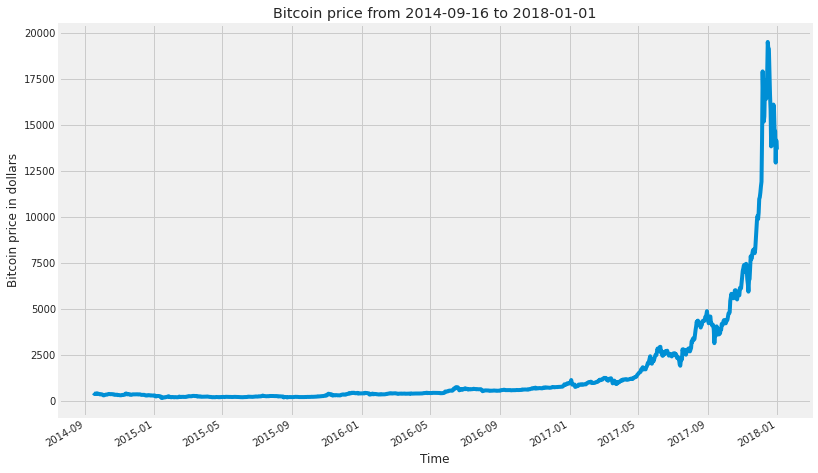

In [5]:
plt.figure(figsize=(12,8))
bitcoin_df['Close'].plot()
plt.xlabel('Time')
plt.ylabel('Bitcoin price in dollars')
plt.title('Bitcoin price from 2014-09-16 to 2018-01-01')
plt.show()

Here, we study the calculate the log returns because it is the variable we will be working with throughout the project.

In [6]:
bitcoin_df['Returns']=np.log(bitcoin_df['Adj Close'])-np.log(bitcoin_df['Adj Close'].shift(1))
bitcoin_df

,High,Low,Open,Close,Volume,Adj Close,Returns
Date,,,,,,,
2014-09-16,468.174011,452.421997,465.864014,457.334015,21056800,457.334015,NaN
2014-09-17,456.859985,413.104004,456.859985,424.440002,34483200,424.440002,-0.074643
2014-09-18,427.834991,384.532013,424.102997,394.795990,37919700,394.795990,-0.072402
2014-09-19,423.295990,389.882996,394.673004,408.903992,36863600,408.903992,0.035111
2014-09-20,412.425995,393.181000,408.084991,398.821014,26580100,398.821014,-0.024968
...,...,...,...,...,...,...,...
2017-12-28,15888.400391,13937.299805,15864.099609,14606.500000,12336499712,14606.500000,-0.080977
2017-12-29,15279.000000,14307.000000,14695.799805,14656.200195,13025500160,14656.200195,0.003397
2017-12-30,14681.900391,12350.099609,14681.900391,12952.200195,14452599808,12952.200195,-0.123598


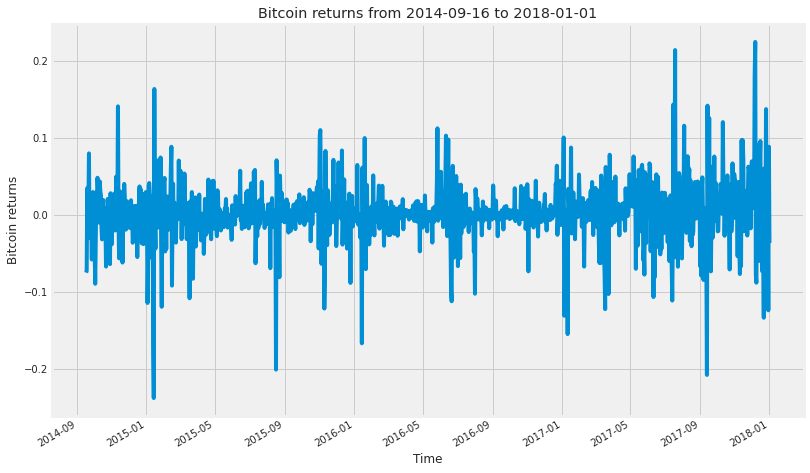

In [7]:
plt.figure(figsize=(12,8))
bitcoin_df['Returns'].plot()
plt.xlabel('Time')
plt.ylabel('Bitcoin returns')
plt.title('Bitcoin returns from 2014-09-16 to 2018-01-01')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


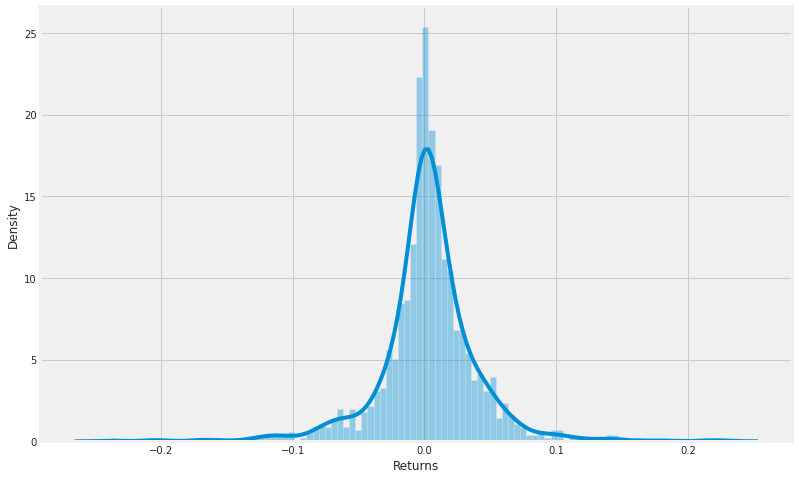

In [8]:
plt.figure(figsize=(12,8))
sns.distplot(bitcoin_df['Returns'].dropna(), bins=100)

In [9]:
bitcoin_df['Returns'].describe()

count    1202.000000
mean        0.002826
std         0.038060
min        -0.237558
25%        -0.010002
50%         0.002421
75%         0.018098
max         0.225119
Name: Returns, dtype: float64

In [10]:
print('Kurtosis: ', pd.DataFrame(bitcoin_df['Returns']).kurtosis()[0])
print('Skewness: ',pd.DataFrame(bitcoin_df['Returns']).skew()[0])

Kurtosis:  6.842005914440319
Skewness:  -0.28966800691422456


In [11]:
bitcoin_returns=bitcoin_df['Returns'].dropna().to_numpy()
print(stats.jarque_bera(bitcoin_returns))
print(stats.shapiro(bitcoin_returns))

(2338.475904255357, 0.0)
(0.8932676315307617, 4.626729394431996e-28)


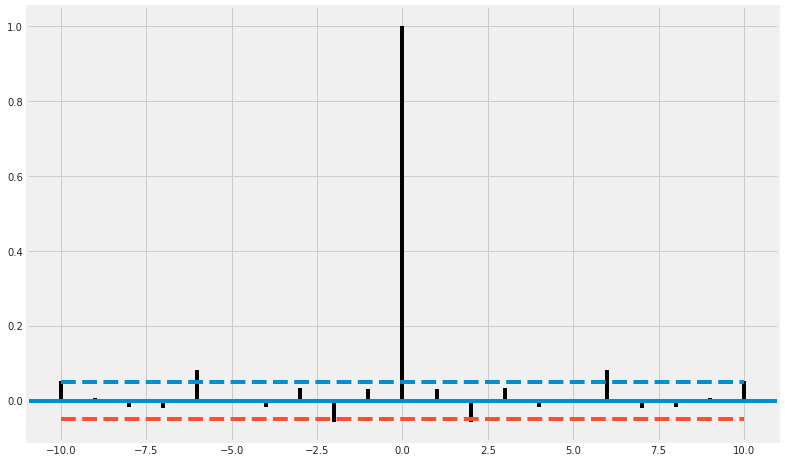

In [12]:
#Autocorrelation plot
plt.figure(figsize=(12,8))
plt.acorr(bitcoin_returns)
plt.plot(range(-10,11),0.05*np.ones((21,)),'--')
plt.plot(range(-10,11),-0.05*np.ones((21,)),'--')

In [13]:
sm.stats.diagnostic.acorr_ljungbox(bitcoin_returns,lags=10)

(array([ 0.84488955,  5.50415537,  6.35621861,  6.94315752,  6.96839756,
        14.19203647, 15.08459483, 15.76233279, 15.76239749, 18.38950714]),
 array([0.35800209, 0.06379518, 0.09550866, 0.13892275, 0.22300125,
        0.02756305, 0.03493018, 0.04591097, 0.07201222, 0.04873805]))

In [14]:
sm.tsa.stattools.adfuller(bitcoin_returns)

(-25.842205322040268,
 0.0,
 1,
 1200,
 {'1%': -3.435811119579282,
  '10%': -2.5680539506944444,
  '5%': -2.8639515467824075},
 -4363.553064011563)

To study the effect of the second halving day on bitcoin retruns we chose to study in detail the time period ranging from 10 days before the halving to 10 days after.


In [15]:
actual_returns=bitcoin_df.loc['2016-06-30':'2016-07-20']['Returns'].to_numpy()
average_return=np.mean(actual_returns)
abnormal_returns=actual_returns-average_return
print(average_return)
bitcoin_halving_df=pd.DataFrame(abnormal_returns,index=range(-10,11))
bitcoin_halving_df

-0.0005924185090283849


,0
-10,0.004977
-9,0.040317
-8,-0.065549
-7,0.037843
-6,-0.018658
-5,0.010539
-4,-0.055222
-3,0.040321
-2,-0.023034
-1,-0.001869


In [16]:
stats.ttest_ind(actual_returns,abnormal_returns)

Ttest_indResult(statistic=-0.06992950456150791, pvalue=0.9445982120678488)

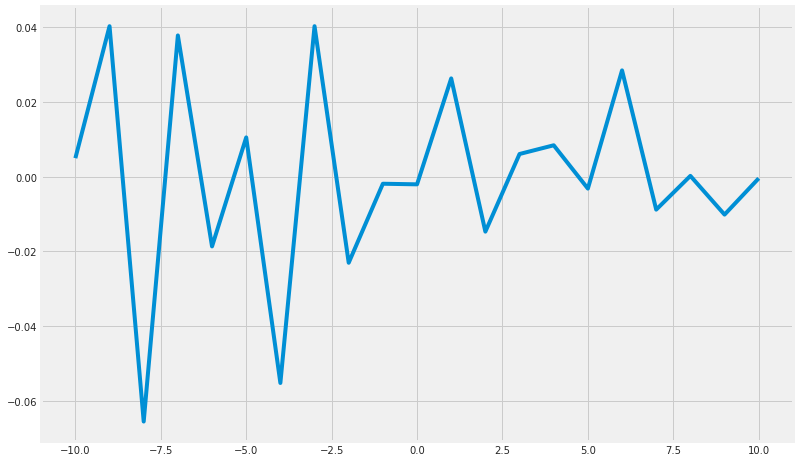

In [17]:
plt.figure(figsize=(12,8))
plt.plot(bitcoin_halving_df)
plt.show()